In [82]:
import os
import esa_snappy
from esa_snappy import GPF, ProductIO, HashMap, jpy
import subprocess
from pathlib import Path

## Functions

In [100]:
def read(filename):
    return ProductIO.readProduct(filename)

def write(product, filename):
    ProductIO.writeProduct(product, filename, "BEAM-DIMAP")
    # Allowed formats to write: GeoTIFF-BigTIFF,HDF5,Snaphu,BEAM-DIMAP,
	# GeoTIFF+XML,PolSARPro,NetCDF-CF,NetCDF-BEAM,ENVI,JP2,
    # Generic Binary BSQ,Gamma,CSV,NetCDF4-CF,GeoTIFF,NetCDF4-BEAM

def topsar_split(product, swath):
    HashMap = jpy.get_type('java.util.HashMap')
    parameters = HashMap()
    parameters.put('subswath', swath)
    parameters.put('selectedPolarisations', 'VV')
    return GPF.createProduct("TOPSAR-Split", parameters, product)

def apply_orbit_file(product):  
    HashMap = jpy.get_type('java.util.HashMap')
    parameters = HashMap()
    parameters.put("Orbit State Vectors", "Sentinel Precise (Auto Download)")
    parameters.put("Polynomial Degree", 3)    
    return GPF.createProduct("Apply-Orbit-File", parameters, product)

def back_geocoding(product): 
    HashMap = jpy.get_type('java.util.HashMap')
    parameters = HashMap()
    parameters.put("Digital Elevation Model", "SRTM 1Sec HGT (Auto Download)")
    # parameters.put("DEM Resampling Method", "BICUBIC_INTERPOLATION")
    # parameters.put("Resampling Type", "BISINC_5_POINT_INTERPOLATION")
    # parameters.put("Mask out areas with no elevation", True)
    # parameters.put("Output Deramp and Demod Phase", False)    
    return GPF.createProduct("Back-Geocoding", parameters, product)

def interferogram(product):
    HashMap = jpy.get_type('java.util.HashMap')
    parameters = HashMap()
    parameters.put("Subtract flat-earth phase", True)
    # parameters.put("Degree of \"Flat Earth\" polynomial", 5)
    # parameters.put("Number of \"Flat Earth\" estimation points", 501)
    # parameters.put("Orbit interpolation degree", 3)
    parameters.put("Include coherence estimation", True)
    parameters.put("Square Pixel", True)
    # parameters.put("Independent Window Sizes", False)
    parameters.put("Coherence Azimuth Window Size", 5)
    parameters.put("Coherence Range Window Size", 5)
    return GPF.createProduct("Interferogram", parameters, product)

def topsar_deburst(product):
    HashMap = jpy.get_type('java.util.HashMap')
    parameters = HashMap()
    parameters.put("Polarisations", "VV")
    return GPF.createProduct("TOPSAR-Deburst", parameters, product)

def multilook(prod, n_range_looks=4, n_azimuth_looks=1):
    HashMap = jpy.get_type('java.util.HashMap')
    parameters = HashMap()
    params = HashMap()
    params.put('nRangeLooks', n_range_looks)
    params.put('nAzimuthLooks', n_azimuth_looks)
    params.put('grSquarePixel', True)
    return GPF.createProduct('Multilook', params, prod)

def terrain_correction(source, proj):
    parameters = HashMap()
    parameters.put('demName', 'SRTM 1Sec HGT')
    parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
    parameters.put('mapProjection', proj)       # comment this line if no need to convert to UTM/WGS84, default is WGS84
    # parameters.put('saveProjectedLocalIncidenceAngle', True)
    # parameters.put('saveSelectedSourceBand', True)
    output = GPF.createProduct('Terrain-Correction', parameters, source)
    return output

def find_coh_band(prod):
    names = list(prod.getBandNames())
    for n in names:
        if n.lower().startswith("coh_") or "coh" in n.lower():
            return n
    raise RuntimeError(f"No coherence band found. Bands: {names}")

def subset_to_band(prod, band_name):
    params = HashMap()
    params.put("bandNames", band_name)   # comma-separated list also accepted
    return GPF.createProduct("Subset", params, prod)

def write_coherence_geotiff(tc_prod, out_tif_path, bigtiff=True):
    """
    tc_prod: terrain-corrected Product (already in UTM/projection you want)
    out_tif_path: "/path/coh_20250702_20250807.tif"
    """
    coh_band = find_coh_band(tc_prod)
    coh_only = subset_to_band(tc_prod, coh_band)

    fmt = "GeoTIFF-BigTIFF" if bigtiff else "GeoTIFF"
    ProductIO.writeProduct(coh_only, out_tif_path, fmt)

    return out_tif_path, coh_band

## Get SLCs, extract dates, sort, create pairs

In [101]:
raw_dir = Path("raw")

In [102]:
slcs = list(raw_dir.iterdir())

In [103]:
def extract_date(x):
    return str(x).split("_")[5].split('T')[0]

In [104]:
slc_sorted = sorted(slcs, key=extract_date)

In [105]:
slc_pairs = list(zip(slc_sorted, slc_sorted[1:]))

In [106]:
slc_pairs[:2]

[(PosixPath('raw/S1C_IW_SLC__1SDV_20250702T040438_20250702T040506_003036_0062D6_6299.zip'),
  PosixPath('raw/S1C_IW_SLC__1SDV_20250807T040440_20250807T040508_003561_007226_55A3.zip')),
 (PosixPath('raw/S1C_IW_SLC__1SDV_20250807T040440_20250807T040508_003561_007226_55A3.zip'),
  PosixPath('raw/S1C_IW_SLC__1SDV_20250819T040441_20250819T040508_003736_007768_F305.zip'))]

## Process each pair, save coherence GeoTIFF

In [107]:
swath = 'IW3'

for pair in slc_pairs[:1]:

    print("Reading SAR data...")
    prod1 = read(str(pair[0]))
    prod2 = read(str(pair[1]))

    print("TOPSAR split...")
    prod1 = topsar_split(prod1, swath)
    prod2 = topsar_split(prod2, swath)

    print("Apply orbit files...")
    prod1 = apply_orbit_file(prod1)
    prod2 = apply_orbit_file(prod2)

    # print("TOPSAR deburst...")
    # prod1 = topsar_deburst(prod1)
    # prod2 = topsar_deburst(prod2)

    # print("Multilook...")
    # prod1 = multilook(prod1)
    # prod2 = multilook(prod2)

    print("Back-geocoding...")
    backGeocoding = back_geocoding([prod1, prod2])

    print("Interferogram...")
    interferogram_formation = interferogram(backGeocoding)

    print("Deburst...")
    deburst = topsar_deburst(interferogram_formation)

    print("Multilook...")
    mlc = multilook(deburst)

    print("Terrain correction...")
    terrain = terrain_correction(mlc, str(32635))

    out_path, band = write_coherence_geotiff(
        terrain,
        f"coherence/{extract_date(str(pair[0]))}_{extract_date(str(pair[1]))}.tif",
        bigtiff=True
    )
    print("Wrote:", out_path, "band:", band)

Reading SAR data...
TOPSAR split...

100% done.

100% done.
Apply orbit files...

100% done.

Back-geocoding...
100% done.

100% done.
Interferogram...

100% done.

100% done.

100% done.
Terrain correction...

100% done.

100% done.


INFO: org.esa.snap.dataio.bigtiff.BigGeoTiffProductWriter: writing to output file coherence/20250702_20250807.tif
INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://step.esa.int/auxdata/dem/SRTMGL1/N14E024.SRTMGL1.hgt.zip
INFO: org.esa.snap.core.dataop.dem.ElevationFile: http retrieving http://step.esa.int/auxdata/dem/SRTMGL1/N13E024.SRTMGL1.hgt.zip


Wrote: coherence/20250702_20250807.tif band: coh_IW3_VV_07Aug2025_02Jul2025


In [108]:
import rasterio

tif_path = "coherence/20250702_20250807.tif"

with rasterio.open(tif_path) as ds:
    print("CRS:", ds.crs)
    print("Transform:", ds.transform)
    print("Width, Height:", ds.width, ds.height)
    print("Count (bands):", ds.count)
    print("Dtype:", ds.dtypes)
    print("NoData:", ds.nodata)

CRS: EPSG:32635
Transform: | 13.98, 0.00, 273858.58|
| 0.00,-13.98, 1630969.81|
| 0.00, 0.00, 1.00|
Width, Height: 7971 13155
Count (bands): 1
Dtype: ('float32',)
NoData: None


In [109]:
import numpy as np
import rasterio

with rasterio.open(tif_path) as ds:
    coh = ds.read(1)              # first (and only) band
    nodata = ds.nodata

# Mask nodata if present
if nodata is not None:
    coh = np.where(coh == nodata, np.nan, coh)

print("Min / Max:", np.nanmin(coh), np.nanmax(coh))
print("Mean:", np.nanmean(coh))

Min / Max: 0.0 0.9945525
Mean: 0.13961665


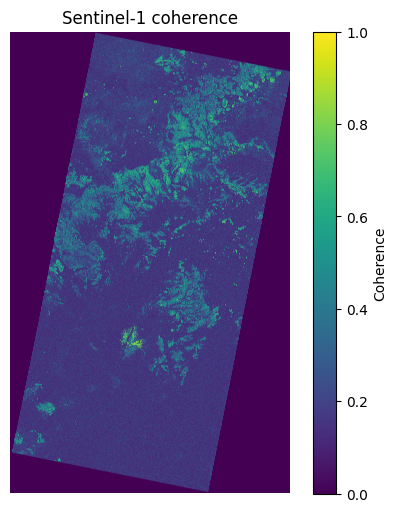

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
im = plt.imshow(coh, cmap="viridis", vmin=0, vmax=1)
plt.colorbar(im, label="Coherence")
plt.title("Sentinel-1 coherence")
plt.axis("off")
plt.show()